This notebook presents a positional comparison of timing and Gaia+VLBI astrometric solutions, assuming that the misalignment between Gaia and VLBI celestial frames is much smaller than those between timing and Gaia or VLBI frames.

In all, I consider DE200, DE405, DE421, DE430, and DE436 in this notebook.

- Remove two pulsars (PSR J1435-6100 and PSR J1955+2908) that are most likely not ture associations for the Gaia pulsar sample and one pulsar (PSR J1546-5302) that does not have proper motion and parallax estimates in the Gaia EDR3.

- Remove all data points with offset greater than 1 arcsec in the absolute sense in either RA or Dec. Such a discrepancy is unlikely linked to the frame mis-alignment. **(2022-05-05)** 

- Remove PSRs near the Ecliptic plane, i.e., the ecliptic latitude is within $\pm\,5\,^{\circ}$. **(2022-06-10)** 

- Fix a serious bug in computing the RA offset and its uncertainty **(2022-08-13)**

In [1]:
from functools import reduce

import numpy as np
import seaborn as sns
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table, join, vstack
from astropy.time import Time
from matplotlib import pyplot as plt
from psrcrf_tools import *
from statsmodels.iolib.table import SimpleTable

/Users/Neo/Scisoft/miniconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 1 Data preparation

Prepare the data for further analyses.

## 1.1 Load the database


### A) Gaia and timing solutions

Read the timing solution data.

In [2]:
timing_table = Table.read(
    "../data/timing_edr3.fits",
)
timing_table.sort("psr_name")

Remove two pulsars (PSR J1435-6100 and PSR J1955+2908) that are most likely not ture associations and one pulsar (PSR J1546-5302) that does not have proper motion and parallax estimates in the *Gaia* EDR3.

In [3]:
mask = (
    (timing_table["psr_name"] != "J1435-6100")
    & (timing_table["psr_name"] != "J1955+2908")
    & (timing_table["psr_name"] != "J1546-5302")
)
timing_table = Table(timing_table[mask], masked=False)

Add unit information

In [4]:
timing_table["ra"].unit = u.deg
timing_table["dec"].unit = u.deg
timing_table["pmra"].unit = u.mas / u.yr
timing_table["pmdec"].unit = u.mas / u.yr
timing_table["plx"].unit = u.mas
timing_table["ra_err"].unit = u.mas
timing_table["dec_err"].unit = u.mas
timing_table["pmra_err"].unit = u.mas / u.yr
timing_table["pmdec_err"].unit = u.mas / u.yr
timing_table["plx_err"].unit = u.mas

Load the cross-match table.

In [5]:
# edr3_antf_table = Table.read("../data/edr3_psrcatv1.65.fits")
# edr3_antf_table = Table.read("../data/edr3_psrcatv1.66.fits")
edr3_antf_table = Table.read("../data/edr3_psrcatv1.67.fits")

Find millisecond pulsars (MSPs) using the classification provided in J. Antoiniadis (2021).

In [6]:
B_over_G = 3.2e19 * np.sqrt(edr3_antf_table["p0"] * edr3_antf_table["p1"])

mask = (B_over_G <= 1e10)
msp_list = edr3_antf_table["name"][mask]

Only keep the astrometric parameters from Gaia.

In [7]:
edr3_antf_table = edr3_antf_table[
    "name",
    "source_id",
    "ra",
    "ra_error",
    "dec",
    "dec_error",
    "parallax",
    "parallax_error",
    "pmra",
    "pmra_error",
    "pmdec",
    "pmdec_error",
]

edr3_antf_table.rename_columns(
    [
        "name",
        "ra_error",
        "dec_error",
        "parallax",
        "parallax_error",
        "pmra_error",
        "pmdec_error",
    ],
    ["psr_name", "ra_err", "dec_err", "plx", "plx_err", "pmra_err", "pmdec_err"],
)

Add unit information

In [8]:
edr3_antf_table["ra"].unit = u.deg
edr3_antf_table["dec"].unit = u.deg
edr3_antf_table["pmra"].unit = u.mas / u.yr
edr3_antf_table["pmdec"].unit = u.mas / u.yr
edr3_antf_table["plx"].unit = u.mas
edr3_antf_table["ra_err"].unit = u.mas
edr3_antf_table["dec_err"].unit = u.mas
edr3_antf_table["pmra_err"].unit = u.mas / u.yr
edr3_antf_table["pmdec_err"].unit = u.mas / u.yr
edr3_antf_table["plx_err"].unit = u.mas

Only consider the MSPs in the data.

In [9]:
temp_table = Table([])

for msp_name in msp_list:
    mask = timing_table["psr_name"] == msp_name
    temp_table = vstack((temp_table, timing_table[mask]))

timing_table = Table(temp_table, masked=False)

Supplement the timing table with the Gaia astrometric information.

In [10]:
edr3_timing = join(
    timing_table,
    edr3_antf_table,
    keys="psr_name",
    join_type="left",
    table_names=["t", "g"],
)

count_psr_nb(edr3_timing)

There are 13 pulsars with 37 measurements.


### B) VLBI and timing solutions

Read the timing solution data.

In [11]:
timing_table = Table.read(
    "../data/timing_vlbi.fits",
)

timing_table["ra"].unit = u.deg
timing_table["dec"].unit = u.deg
timing_table["pmra"].unit = u.mas / u.yr
timing_table["pmdec"].unit = u.mas / u.yr
timing_table["plx"].unit = u.mas
timing_table["ra_err"].unit = u.mas
timing_table["dec_err"].unit = u.mas
timing_table["pmra_err"].unit = u.mas / u.yr
timing_table["pmdec_err"].unit = u.mas / u.yr
timing_table["plx_err"].unit = u.mas

In [12]:
msp_list = [
    "J1022+1001", "J2010-1323", "J2145-0750", "J2317+1439", "J1012+5307", "J1537+1155"
]

temp_table = Table([])

for msp_name in msp_list:
    mask = timing_table["psr_name"] == msp_name
    temp_table = vstack((temp_table, timing_table[mask]))

timing_table = Table(temp_table, masked=False)

Load PSRPI solution.

In [13]:
vlbi_table = Table.read("../data/psrpi.dat", format="ascii")

vlbi_table["ra"].unit = u.deg
vlbi_table["dec"].unit = u.deg
vlbi_table["pmra"].unit = u.mas / u.yr
vlbi_table["pmdec"].unit = u.mas / u.yr
vlbi_table["plx"].unit = u.mas
vlbi_table["ra_err"].unit = u.mas
vlbi_table["dec_err"].unit = u.mas
vlbi_table["pmra_err"].unit = u.mas / u.yr
vlbi_table["pmdec_err"].unit = u.mas / u.yr
vlbi_table["plx_err"].unit = u.mas

Join these two solutions.

In [14]:
vlbi_timing = join(
    timing_table, vlbi_table, keys="psr_name", join_type="left", table_names=["t", "g"]
)

vlbi_timing.rename_column("pos_epoch_t", "pos_epoch")

count_psr_nb(vlbi_timing)

There are 6 pulsars with 46 measurements.


## 1.2 Compute offsets between pulsar positions from timing and Gaia

Propagate the Gaia EDR3 position from J2016.0 to the timing positonal epoch and compute the positional offset,
in the sense of timing minus Gaia.

In [15]:
gaia_epoch = Time("2016.0", format="jyear").mjd
# 57388.5

# Epoch difference in Julian year
dt_y = (edr3_timing["pos_epoch"].value - gaia_epoch) / 365.25 * u.yr

# Cos(decl.) factor for the difference in R.A.
dec_fac = cos(np.deg2rad(edr3_timing["dec_g"].value))

dra = (
    edr3_timing["ra_t"] - edr3_timing["ra_g"]
) * dec_fac - dt_y * edr3_timing["pmra_g"]

ddec = edr3_timing["dec_t"] - edr3_timing["dec_g"] - \
    dt_y * edr3_timing["pmdec_g"]

dra = dra.to(u.mas)
ddec = ddec.to(u.mas)

edr3_timing.add_columns([dra, ddec], names=["dra", "ddec"])

In [16]:
edr3_timing["ra_err_t"] = edr3_timing["ra_err_t"] * dec_fac

dra_err = np.sqrt(
    edr3_timing["ra_err_g"] ** 2
    + edr3_timing["ra_err_t"] ** 2
    + (dt_y * edr3_timing["pmra_err_g"]).value ** 2
)

ddec_err = np.sqrt(
    edr3_timing["dec_err_g"] ** 2
    + edr3_timing["dec_err_t"] ** 2
    + (dt_y * edr3_timing["pmdec_err_g"]).value ** 2
)

edr3_timing.add_columns([dra_err, ddec_err], names=["dra_err", "ddec_err"])

Propagate the VLBI position from its epoch to the timing positonal epoch and compute the positional offset,
in the sense of timing minus VLBI.

In [17]:
# Epoch difference in Julian year
dt_y = (vlbi_timing["pos_epoch"].value -
        vlbi_timing["pos_epoch_g"]) / 365.25 * u.yr

# Cos(decl.) factor for the difference in R.A.
dec_fac = cos(np.deg2rad(vlbi_timing["dec_g"].value))

dra = (
    vlbi_timing["ra_t"] - vlbi_timing["ra_g"]
) * dec_fac - dt_y * vlbi_timing["pmra_g"]

ddec = vlbi_timing["dec_t"] - vlbi_timing["dec_g"] - \
    dt_y * vlbi_timing["pmdec_g"]

dra = dra.to(u.mas)
ddec = ddec.to(u.mas)

vlbi_timing.add_columns([dra, ddec], names=["dra", "ddec"])

In [18]:
vlbi_timing["ra_err_t"] = vlbi_timing["ra_err_t"] * dec_fac

dra_err = np.sqrt(
    vlbi_timing["ra_err_g"] ** 2
    + vlbi_timing["ra_err_t"] ** 2
    + (dt_y * vlbi_timing["pmra_err_g"]).value ** 2
)

ddec_err = np.sqrt(
    vlbi_timing["dec_err_g"] ** 2
    + vlbi_timing["dec_err_t"] ** 2
    + (dt_y * vlbi_timing["pmdec_err_g"]).value ** 2
)

vlbi_timing.add_columns([dra_err, ddec_err], names=["dra_err", "ddec_err"])

Join the Gaia-timing and VLBI-timing tables.

In [19]:
gv_timing = vstack((edr3_timing, vlbi_timing))

count_psr_nb(gv_timing)

There are 18 pulsars with 83 measurements.


## 1.3 Plot the sky distribution

Find pulsars according to the underlying reference frames the time positions are referring to.

In [20]:
mask = gv_timing["eph"] == "DE200"
gv_timing200 = gv_timing[mask]

mask = gv_timing["eph"] == "DE405"
gv_timing405 = gv_timing[mask]

mask = gv_timing["eph"] == "DE421"
gv_timing421 = gv_timing[mask]

mask = gv_timing["eph"] == "DE430"
gv_timing430 = gv_timing[mask]

mask = gv_timing["eph"] == "DE436"
gv_timing436 = gv_timing[mask]

I plot the distribution for all pulsars in one figure.

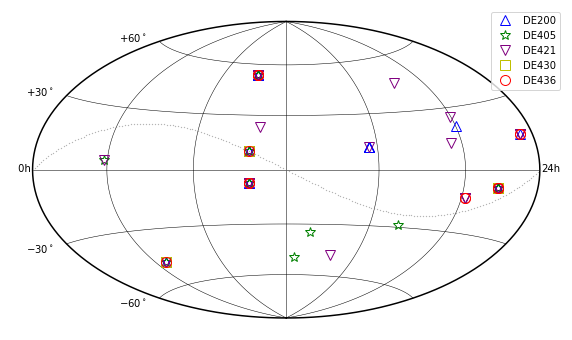

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis("off")

# Uniform sampling in longtitude and latitude
lon_arr = np.arange(0, 361, 5)
lat_arr = np.arange(-90, 91, 1)

# Plot a ellipse border.
lon_bords = np.array([0, 360])

# A loop to plot 7 grid.
for lon_bord in lon_bords:
    lat = lat_arr
    lon = np.ones_like(lat) * lon_bord
    X, Y = hammer_projection(lon, lat)
    ax.plot(X, Y, "k", linewidth=1.5)

# Grid plot.
# longtitude_grid_plot()
# 6 nodes in the longtitude from 0 to 360 deg.
lon_nodes = np.arange(60, 360, 60)

# A loop to plot 7 grid.
for lon_node in lon_nodes:
    lat = lat_arr
    lon = np.ones_like(lat) * lon_node
    X, Y = hammer_projection(lon, lat)
    ax.plot(X, Y, "k", linewidth=0.5)

# latitude_grid_plot()
# 5 nodes in the latitude from -60 to +60 deg.
lat_nodes = np.arange(-60, 61, 30)

# A loop to plot 7 grid.
for lat_node in lat_nodes:
    lon = lon_arr
    lat = np.ones_like(lon) * lat_node
    X, Y = hammer_projection(lon, lat)
    ax.plot(X, Y, "k", linewidth=0.5)

# Grid tickers.
# For fundamental plane.
lon0 = np.array([0, 360])
lat0 = np.array([0, 0])
X0, Y0 = hammer_projection(lon0, lat0)

ax.text(X0[0] - 0.2, Y0[0] - 0.025, " 0h")
ax.text(X0[1] + 0.02, Y0[1] - 0.025, "24h")

# For latitude grid
lon = np.array([0, 0])
lat = np.array([30, 60])
X, Y = hammer_projection(lon, lat)

for i in range(lat.size):
    ax.text(X[i] - 0.45, Y[i] - 0.0, "$+%d^\circ$" % lat[i])
    ax.text(X[i] - 0.45, -Y[i] - 0.1, "$-%d^\circ$" % lat[i])

# Plot the source.
shift = 0.025
# DE200
X, Y = hammer_projection(gv_timing200["ra_g"], gv_timing200["dec_g"])
ax.plot(X, Y, "^", mfc="none", mec="b", ms=10, label="DE200")

# DE405
X, Y = hammer_projection(gv_timing405["ra_g"], gv_timing405["dec_g"])
ax.plot(X, Y, "*", mfc="none", mec="g", ms=10, label="DE405")

# DE421
X, Y = hammer_projection(gv_timing421["ra_g"], gv_timing421["dec_g"])
ax.plot(X, Y, "v", mfc="none", mec="purple", ms=10, label="DE421")

# DE430
X, Y = hammer_projection(gv_timing430["ra_g"], gv_timing430["dec_g"])
ax.plot(X, Y, "s", mfc="none", mec="y", ms=10, label="DE430")

# DE436
X, Y = hammer_projection(gv_timing436["ra_g"], gv_timing436["dec_g"])
ax.plot(X, Y, "o", mfc="none", mec="r", ms=10, label="DE436")

# Ecliptic plane
lon_arr = np.arange(0, 361, 2)
lat_arr = np.zeros_like(lon_arr)
ecl_plane = SkyCoord(lon_arr, lat_arr, unit="deg",
                     frame="barycentricmeanecliptic")
ecl_plane_equ = ecl_plane.icrs
ecl_ra = ecl_plane_equ.ra.value
ecl_dec = ecl_plane_equ.dec.value
X, Y = hammer_projection(ecl_ra, ecl_dec)
ax.plot(X, Y, ".", ms=0.5, color="grey")

ax.legend()

## 1.4 Compute statistics of position formal uncertainties

Compute the median positional formal uncertainties for each subset.

In [22]:
# For comparison of positional uncertainty
pos_err_tab = np.zeros((5, 6))

pos_err_tab[0, :] = calc_med_pos_err(gv_timing200)
pos_err_tab[1, :] = calc_med_pos_err(gv_timing405)
pos_err_tab[2, :] = calc_med_pos_err(gv_timing421)
pos_err_tab[3, :] = calc_med_pos_err(gv_timing430)
pos_err_tab[4, :] = calc_med_pos_err(gv_timing436)

/Users/Neo/Scisoft/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


# 2 Compare timing and Gaia+VLBI positions

##  2.1 DE200 vs Gaia EDR3 + PSRpi

In [23]:
mask = gv_timing["eph"] == "DE200"
gv_timing200 = gv_timing[mask]

nb_psr_200 = len(gv_timing200.group_by("psr_name").groups)
nb_obs_200 = len(gv_timing200)

print("We have", nb_psr_200,
      "pulsars in the sample from DE200 vs. Gaia DR3 + PSRpi comparison with",
      nb_obs_200, "observations.")
# gv_timing200

We have 8 pulsars in the sample from DE200 vs. Gaia DR3 + PSRpi comparison with 18 observations.


/Users/Neo/Github/pulsar-crf-comparison/progs/psrcrf_tools.py:666: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


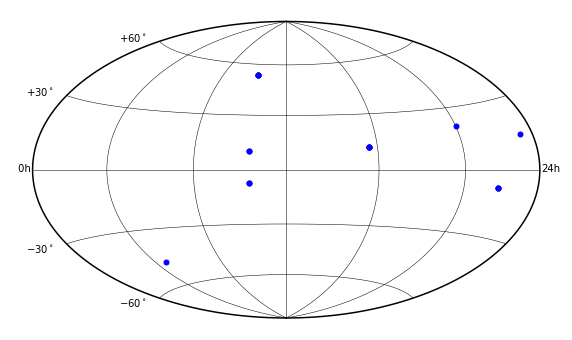

In [24]:
sou_dist_plot(
    gv_timing200["ra_g"],
    gv_timing200["dec_g"])

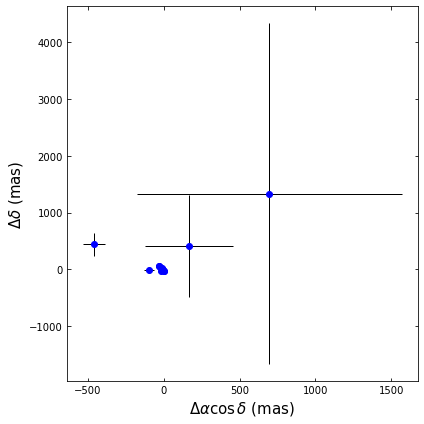

In [25]:
simple_plot(gv_timing200)

First, we check the positional offset visually.

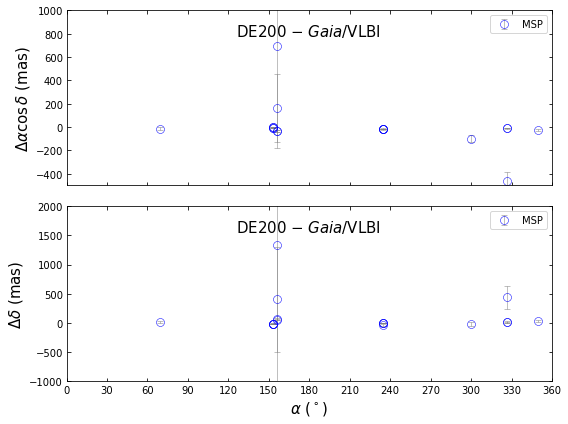

In [26]:
pos_oft_vs_coord(
    gv_timing200,
    [-500, 1000, -1000, 2000],
    # Prefit
    gv_timing200["dra"],
    gv_timing200["ddec"],
    # Postfit
    #                  dra_200,
    #                  ddec_200,
    add_text=[0.35, 0.85, "DE200 $-$ $Gaia$/VLBI"],
    ref="g",
    xaxis="ra",
    divided=True)

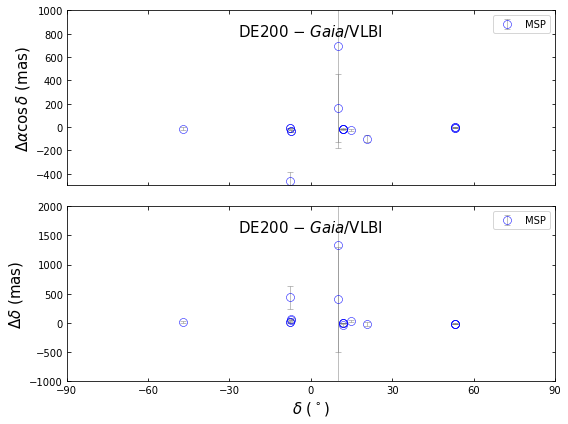

In [27]:
val_max = 1000
pos_oft_vs_coord(
    gv_timing200,
     [-500, 1000, -1000, 2000],
    # Prefit
    gv_timing200["dra"],
    gv_timing200["ddec"],
    # Postfit
    #                  dra_200,
    #                  ddec_200,
    add_text=[0.35, 0.85, "DE200 $-$ $Gaia$/VLBI"],
    ref="g",
    xaxis="dec",
    divided=True)

Change the limits of the X- and Y-axes to remove the extremely large offsets. 

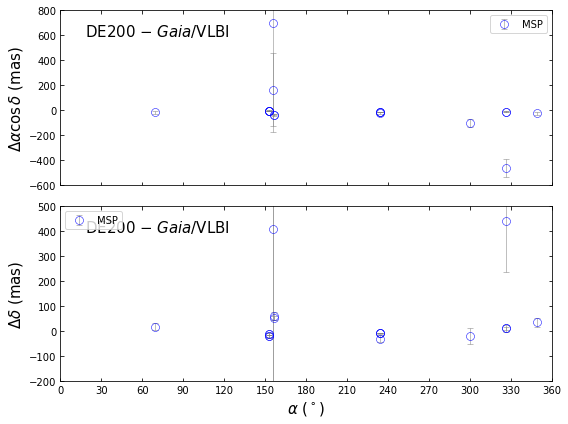

In [28]:
pos_oft_vs_coord(
    gv_timing200,
    [-600, 800, -200, 500],
    # Prefit
    gv_timing200["dra"],
    gv_timing200["ddec"],
    add_text=[0.05, 0.85, "DE200 $-$ $Gaia$/VLBI"],
    ref="g",
    xaxis="ra",
    divided=True)

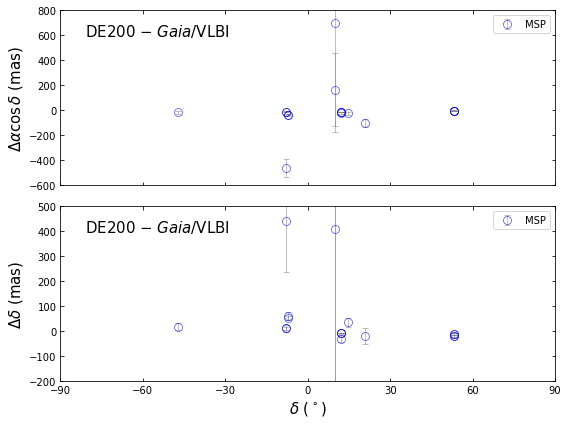

In [29]:
val_max = 1000
pos_oft_vs_coord(
    gv_timing200,
    [-600, 800, -200, 500],
    # Prefit
    gv_timing200["dra"],
    gv_timing200["ddec"],
    add_text=[0.05, 0.85, "DE200 $-$ $Gaia$/VLBI"],
    ref="g",
    xaxis="dec",
    divided=True)

## 2.2 DE405 vs Gaia EDR3

In [30]:
mask = gv_timing["eph"] == "DE405"
gv_timing405 = gv_timing[mask]

nb_psr_405 = len(gv_timing405.group_by("psr_name").groups)
nb_obs_405 = len(gv_timing405)

print("We have", nb_psr_405,
      "pulsars in the sample from DE405 vs. Gaia DR3 + PSRpi comparison with",
      nb_obs_405, "observations.")

# gv_timing405

We have 9 pulsars in the sample from DE405 vs. Gaia DR3 + PSRpi comparison with 13 observations.


Plot the sky distribution.

/Users/Neo/Github/pulsar-crf-comparison/progs/psrcrf_tools.py:666: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


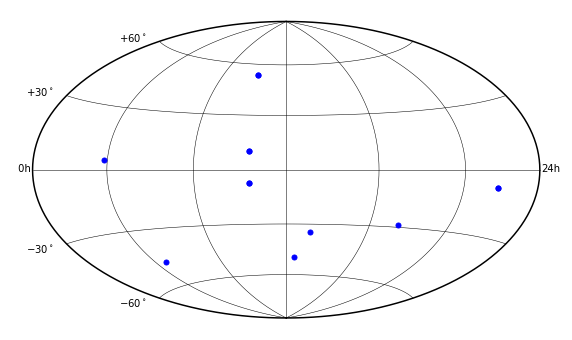

In [31]:
sou_dist_plot(gv_timing405["ra_g"], gv_timing405["dec_g"])

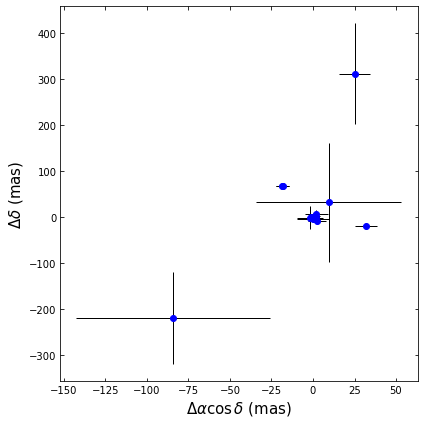

In [32]:
simple_plot(gv_timing405)

Plot the relationship between position offsets and RA/DEC.

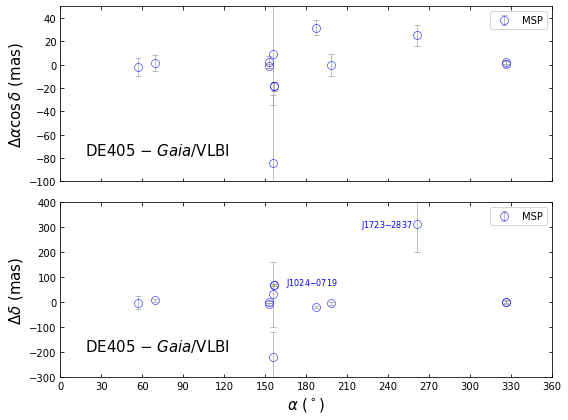

In [33]:
pos_oft_vs_coord(gv_timing405, [-100, 50, -300, 400],
                 gv_timing405["dra"],
                 gv_timing405["ddec"],
                 add_text=[0.05, 0.15, "DE405 $-$ $Gaia$/VLBI"],
                 add_text_msp=[[220, 300, "J1723$-$2837", 1],
                               [165, 70, "J1024$-$0719", 1]],
                 ref="g",
                 xaxis="ra",
                 divided=True)

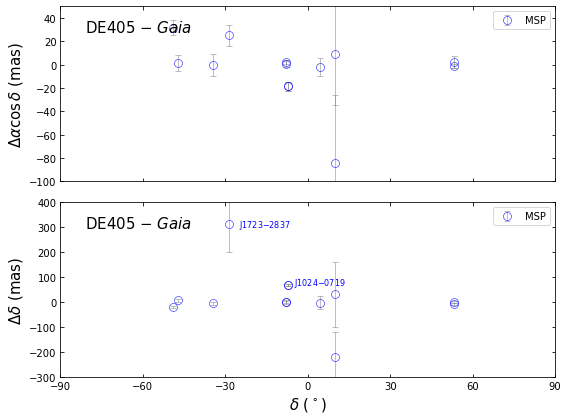

In [34]:
pos_oft_vs_coord(gv_timing405, [-100, 50, -300, 400],
                 gv_timing405["dra"],
                 gv_timing405["ddec"],
                 ref="g",
                 xaxis="dec",
                 add_text=[0.05, 0.85, "DE405 $-$ $Gaia$"],
                 add_text_msp=[[-25, 300, "J1723$-$2837", 1],
                               [-5, 70, "J1024$-$0719", 1]],
                 divided=True)

## 2.3 DE421 vs Gaia EDR3

In [35]:
mask = gv_timing["eph"] == "DE421"
gv_timing421 = gv_timing[mask]

nb_psr_421 = len(gv_timing421.group_by("psr_name").groups)
nb_obs_421 = len(gv_timing421)

print("We have", nb_psr_421,
      "pulsars in the sample from DE421 vs. Gaia DR3 comparison with",
      nb_obs_421, "observations.")

We have 14 pulsars in the sample from DE421 vs. Gaia DR3 comparison with 32 observations.


/Users/Neo/Github/pulsar-crf-comparison/progs/psrcrf_tools.py:666: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


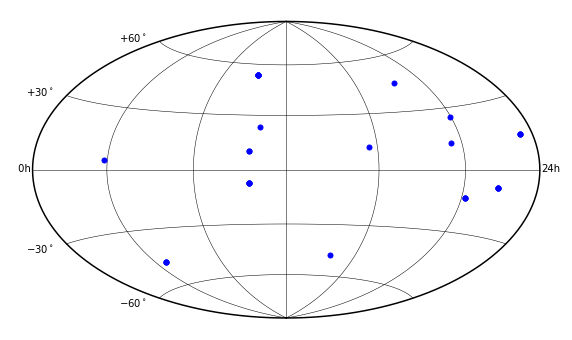

In [36]:
sou_dist_plot(gv_timing421["ra_g"], gv_timing421["dec_g"])

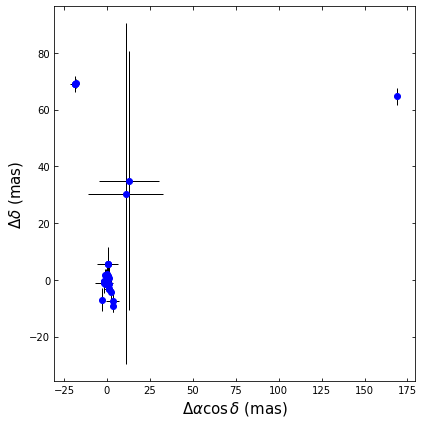

In [37]:
simple_plot(gv_timing421)

Obviously, there is one measurment is far from the other points.

Shorten the limits of the X- and Y- axes.

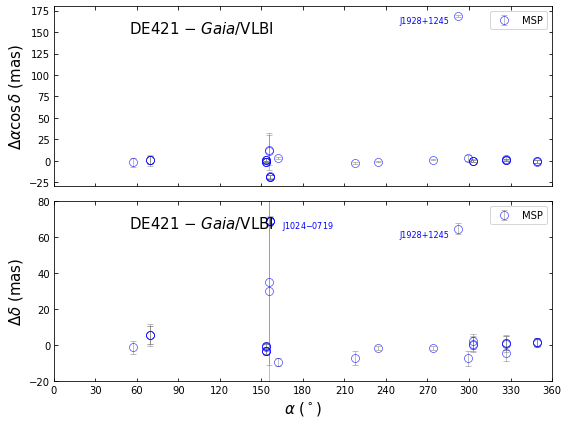

In [38]:
pos_oft_vs_coord(gv_timing421,  [-30, 180, -20, 80],
                 gv_timing421["dra"],
                 gv_timing421["ddec"],
                 add_text=[0.15, 0.85, "DE421 $-$ $Gaia$/VLBI"],
                 add_text_msp=[[250, 160, "J1928+1245", 0],
                               [165, 65, "J1024$-$0719", 1],
                               [250, 60, "J1928+1245", 1]],
                 ref="g",
                 xaxis="ra",
                 divided=True)

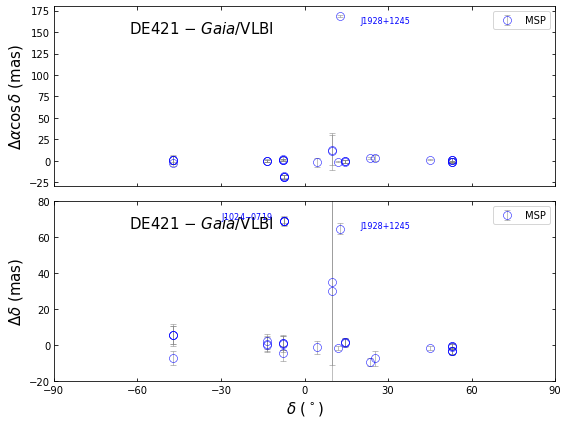

In [39]:
pos_oft_vs_coord(gv_timing421, [-30, 180, -20, 80],
                 gv_timing421["dra"],
                 gv_timing421["ddec"],
                 ref="g",
                 xaxis="dec",
                 add_text=[0.15, 0.85, "DE421 $-$ $Gaia$/VLBI"],
                 add_text_msp=[[20, 160, "J1928+1245", 0],
                               [-30, 70, "J1024$-$0719", 1],
                               [20, 65, "J1928+1245", 1]],
                 divided=True)

## 2.4 DE430 vs Gaia EDR3

In [40]:
mask = gv_timing["eph"] == "DE430"
gv_timing430 = gv_timing[mask]

nb_psr_430 = len(gv_timing430.group_by("psr_name").groups)
nb_obs_430 = len(gv_timing430)

# count_psr_nb(gv_timing430)
print("We have", nb_psr_430,
      "pulsars in the sample from DE430 vs. Gaia DR3 + PSRpi comparison with",
      nb_obs_430, "observations.")
# edr3_timing430

We have 3 pulsars in the sample from DE430 vs. Gaia DR3 + PSRpi comparison with 4 observations.


/Users/Neo/Github/pulsar-crf-comparison/progs/psrcrf_tools.py:666: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


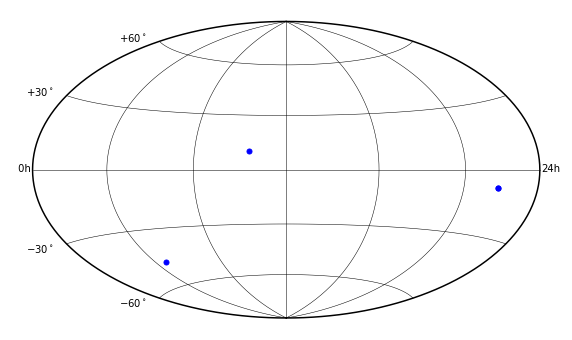

In [41]:
sou_dist_plot(
    gv_timing430["ra_g"],
    gv_timing430["dec_g"],
)

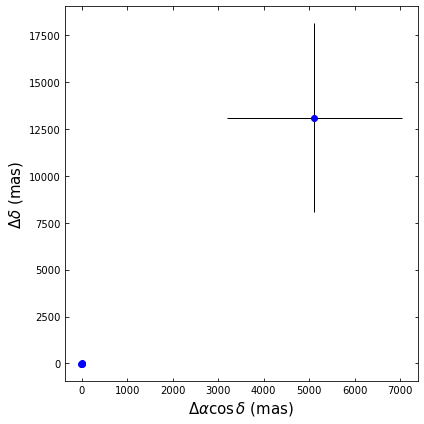

In [42]:
simple_plot(gv_timing430)

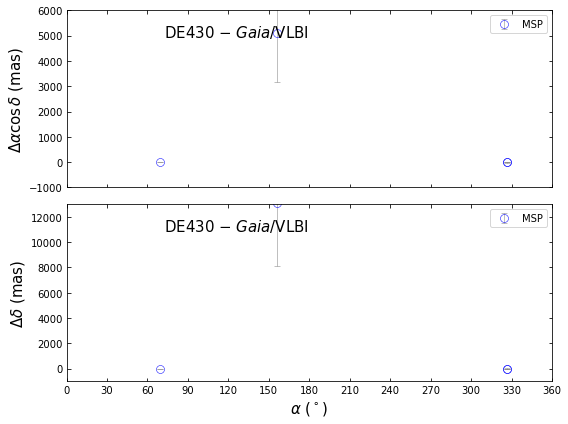

In [43]:
pos_oft_vs_coord(gv_timing430, [-1000, 6000, -1000, 13000],
                 gv_timing430["dra"],
                 gv_timing430["ddec"],
                 add_text=[0.2, 0.85, "DE430 $-$ $Gaia$/VLBI"],
                 ref="g",
                 xaxis="ra",
                 divided=True)

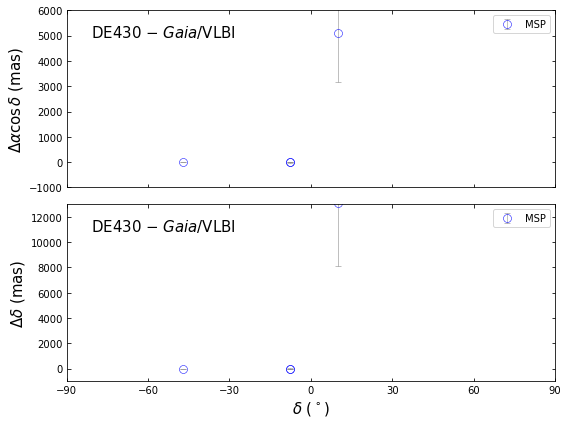

In [44]:
pos_oft_vs_coord(gv_timing430, [-1000, 6000, -1000, 13000],
                 gv_timing430["dra"],
                 gv_timing430["ddec"],
                 add_text=[0.05, 0.85, "DE430 $-$ $Gaia$/VLBI"],
                 ref="g",
                 xaxis="dec",
                 divided=True)

## 2.5 DE436 vs Gaia EDR3

In [45]:
mask = gv_timing["eph"] == "DE436"
gv_timing436 = gv_timing[mask]

nb_psr_436 = len(gv_timing436.group_by("psr_name").groups)
nb_obs_436 = len(gv_timing436)

# count_psr_nb(gv_timing436)
print("We have", nb_psr_436,
      "pulsars in the sample from DE436 vs. Gaia DR3 comparison with",
      nb_obs_436, "observations.")

We have 7 pulsars in the sample from DE436 vs. Gaia DR3 comparison with 16 observations.


/Users/Neo/Github/pulsar-crf-comparison/progs/psrcrf_tools.py:666: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


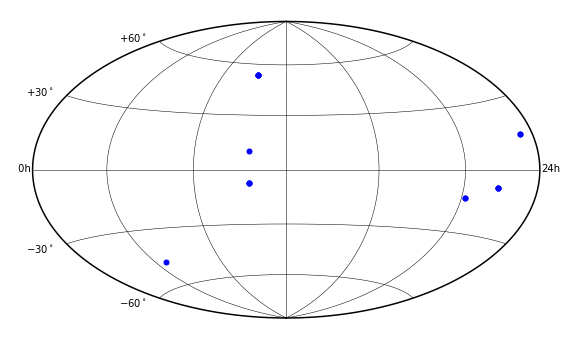

In [46]:
sou_dist_plot(
    gv_timing436["ra_g"],
    gv_timing436["dec_g"],
)

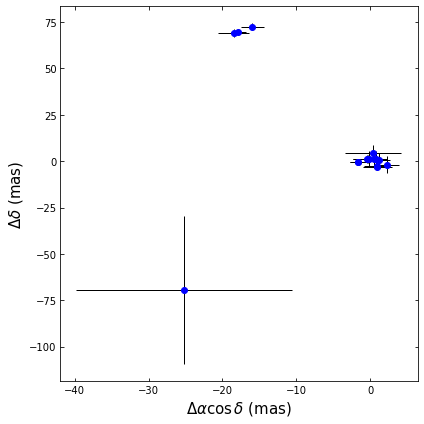

In [47]:
simple_plot(gv_timing436)

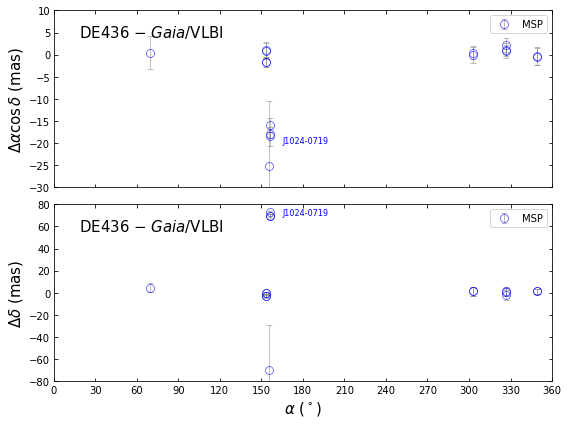

In [48]:
pos_oft_vs_coord(gv_timing436, [-30, 10, -80, 80],
                 gv_timing436["dra"],
                 gv_timing436["ddec"],
                 add_text=[0.05, 0.85, "DE436 $-$ $Gaia$/VLBI"],
                 add_text_msp=[
    [165, -20, "J1024-0719", 0],
    [165, 70, "J1024-0719", 1]],
    ref="g",
    xaxis="ra",
    divided=True)

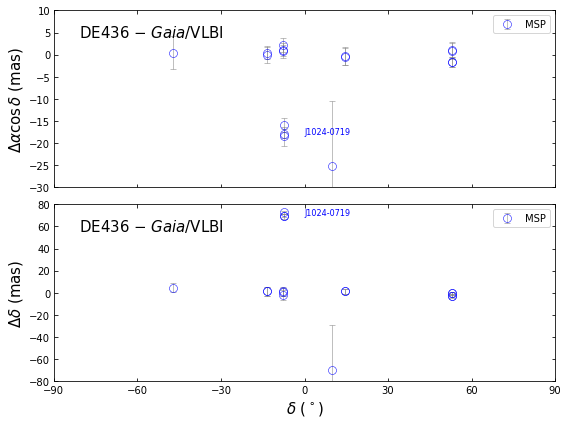

In [49]:
pos_oft_vs_coord(gv_timing436, [-30, 10, -80, 80],
                 gv_timing436["dra"],
                 gv_timing436["ddec"],
                 add_text=[0.05, 0.85, "DE436 $-$ $Gaia$/VLBI"],
                 add_text_msp=[
    [0, -18, "J1024-0719", 0],
    [0, 70, "J1024-0719", 1]],
    ref="g",
    xaxis="dec",
    divided=True)

# 3 Compare timing and Gaia/VLBI reference frames

## 3.1 Remove pulsars near the ecliptic plane

Remove PSRs near the Ecliptic plane within 10 degrees.

In [50]:
mask = (
    (gv_timing["psr_name"] != "J0614+2229")
    & (gv_timing["psr_name"] != "J0534+2200")
    & (gv_timing["psr_name"] != "J0337+1715")
    & (gv_timing["psr_name"] != "J2339-0533")
    #     & (gv_timing["psr_name"] != "J1723-2837")
    #     & (gv_timing["psr_name"] != "J2129-0429")
    #     & (gv_timing["psr_name"] != "J1023+0038")
    & (gv_timing["psr_name"] != "J0614+2229")
    & (gv_timing["psr_name"] != "J0629+2415")
    #     & (gv_timing["psr_name"] != "J0826+2637")
    & (gv_timing["psr_name"] != "J1022+1001")
    & (gv_timing["psr_name"] != "J1257-1027")
    #     & (gv_timing["psr_name"] != "J1650-1654")
    & (gv_timing["psr_name"] != "J1703-1846")
    #     & (gv_timing["psr_name"] != "J2010-1323")
    #     & (gv_timing["psr_name"] != "J2145-0750")
    #     & (gv_timing["psr_name"] != "J2248-0101")
    & (gv_timing["psr_name"] != "J2346-0609")
)
gv_timing = Table(gv_timing[mask], masked=False)

In [51]:
mask = gv_timing["eph"] == "DE200"
gv_timing200 = gv_timing[mask]

mask = gv_timing["eph"] == "DE405"
gv_timing405 = gv_timing[mask]

mask = gv_timing["eph"] == "DE421"
gv_timing421 = gv_timing[mask]

mask = gv_timing["eph"] == "DE430"
gv_timing430 = gv_timing[mask]

mask = gv_timing["eph"] == "DE436"
gv_timing436 = gv_timing[mask]

In [52]:
nb_psr_200 = len(gv_timing200.group_by("psr_name").groups)
nb_obs_200 = len(gv_timing200)

nb_psr_405 = len(gv_timing405.group_by("psr_name").groups)
nb_obs_405 = len(gv_timing405)

nb_psr_421 = len(gv_timing421.group_by("psr_name").groups)
nb_obs_421 = len(gv_timing421)

nb_psr_430 = len(gv_timing430.group_by("psr_name").groups)
nb_obs_430 = len(gv_timing430)

nb_psr_436 = len(gv_timing436.group_by("psr_name").groups)
nb_obs_436 = len(gv_timing436)

## 3.2 DE200 vs. Gaia + VLBI

Do the LSQ fitting iterately.

In [53]:
pmt200, sig200, indx, apr_chi2_200, pst_chi2_200 = rot_fit_4_table(
    gv_timing200)

rot200, iqr200 = find_pmt_est(pmt200)

Iter.  NO.PSR  Apr.Chi2  Pos.Chi2  R1  R2  R3  rmPSR  rmPSREpoch  rmPSRChi2
Unit: mas
 1  7     38.1      6.3       0.99     -10.72     -13.00 J1537+1155    50300      0.1
 2  7     30.3      6.8       1.16     -10.80     -13.00 J1537+1155    50261      0.1
 3  7     21.4      7.3       1.40     -10.92     -13.01 J1537+1155    48778      0.4
 4  7     13.4      8.0       1.78     -11.44     -14.23 J1024-0719    50456     79.8
 5  7     10.7      4.5      -0.70     -13.87     -12.87 J2145-0750    48979     42.0
 6  7      9.4      2.7      -0.81     -13.78     -12.67 J2145-0750    50317      1.8
 7  7      8.4      2.6       4.03     -16.13     -20.45 J1024-0719    51018     23.3
 8  6      7.3      1.3       1.61     -16.03     -17.48 J1012+5307    50700      0.9
 9  6      6.7      1.3       1.87     -17.85     -17.29 J1012+5307    50700      1.1
10  6      6.5      1.5       2.44     -16.45     -17.42 J1012+5307    50914      1.2
11  6      6.3      1.3       6.97     -23.96     -16.

In [54]:
dra_200, ddec_200 = calc_dpos(gv_timing200, rot200)

a_chi2_200, p_chi2_200 = calc_chi2_4_fit(gv_timing200, dra_200, ddec_200)


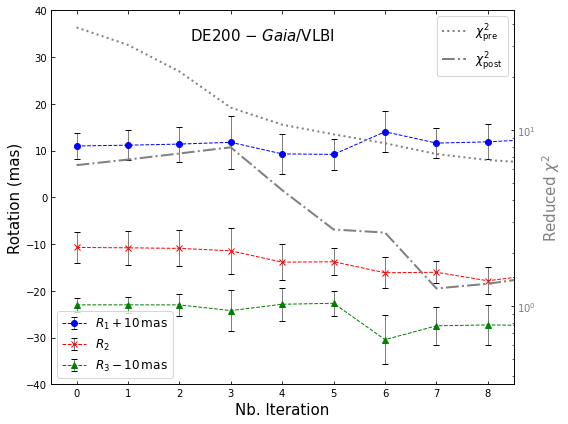

In [55]:
rot_vs_iter(pmt200,
            sig200, [-0.5, 8.5, -40, 40],
            elw=0.5,
            add_text=[0.3, 0.92, "DE200 $-$ $Gaia$/VLBI"],
            apr_chi2=apr_chi2_200,
            pst_chi2=pst_chi2_200,
            ax_loc="lower left",
            ax1_loc="upper right",
            y_shift=10)

## 3.3 DE405 vs Gaia+VLBI

In [56]:
pmt405, sig405, indx, apr_chi2_405, pst_chi2_405 = rot_fit_4_table(
    gv_timing405)

rot405, iqr405 = find_pmt_est(pmt405)

Iter.  NO.PSR  Apr.Chi2  Pos.Chi2  R1  R2  R3  rmPSR  rmPSREpoch  rmPSRChi2
Unit: mas
 1  8     34.4     31.1      11.02       6.64      -2.62 J1024-0719    53000    190.6
 2  8     21.8     21.5       4.94       0.75      -0.62 J1024-0719    53000    240.4
 3  7      6.3      4.7      -2.91      -6.67       2.08 J1227-4853    56708     37.8
 4  6      1.8      1.6      -1.66      -1.02       1.92 J1723-2837    55667     14.1
 5  5      0.6      0.5      -1.09      -0.75       1.42 J1012+5307    50700      1.9
 6  5      0.4      0.3      -0.76       0.42       1.42 J2145-0750    53040      0.2
 7  5      0.3      0.3       0.33       0.13      -0.51 J0437-4715    53019      0.9
 8  4      0.2      0.2      -0.63       0.25      -0.07 J1012+5307    50700      0.2
 9  3      0.3      0.1       1.30      -3.13       0.20 J1311-3430    55267      0.0


In [57]:
dra_405, ddec_405 = calc_dpos(gv_timing405, rot405)

a_chi2_405, p_chi2_405 = calc_chi2_4_fit(gv_timing405, dra_405, ddec_405)

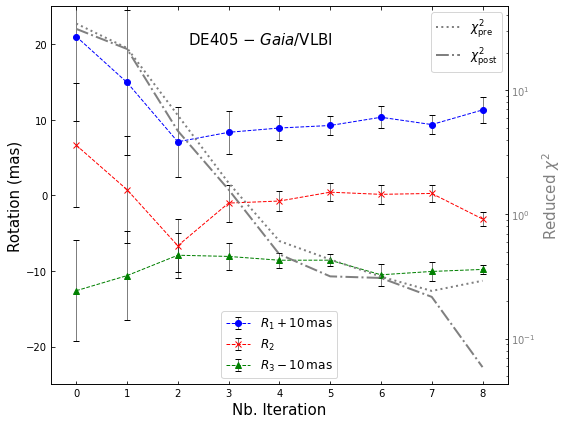

In [58]:
rot_vs_iter(
    pmt405,
    sig405,
    [-0.5, 8.5, -25, 25],
    add_text=[0.3, 0.9, "DE405 $-$ $Gaia$/VLBI"],
    apr_chi2=apr_chi2_405,
    pst_chi2=pst_chi2_405,
    ax_loc="lower center",
    ax1_loc="upper right",
    elw=0.5,
    y_shift=10
)

## 3.4 DE421 vs Gaia

In [59]:
pmt421, sig421, indx, apr_chi2_421, pst_chi2_421 = rot_fit_4_table(
    gv_timing421)

Iter.  NO.PSR  Apr.Chi2  Pos.Chi2  R1  R2  R3  rmPSR  rmPSREpoch  rmPSRChi2
Unit: mas
 1 13    721.6    636.7      -6.06      15.09      18.47 J1928+1245    57974  27318.3
 2 12     85.9     73.6       6.11       8.67      -3.36 J1024-0719    55800   1459.3
 3 12     50.1     46.1       3.71       4.83      -1.97 J1024-0719    55000    783.0
 4 12     33.2     31.7       2.46       2.85      -1.23 J1024-0719    55000    841.8
 5 12     15.0     14.8       1.10       0.73      -0.43 J1024-0719    54500    623.7
 6 11      1.6      1.6       0.11      -0.82       0.17 J1048+2339    56700     23.3
 7 10      1.1      1.1       0.13      -0.37      -0.14 J1816+4510    56047      8.7
 8  9      1.0      0.8      -0.09      -1.22      -0.61 J1431-4715    55756      6.3
 9  8      0.9      0.7      -0.56      -1.26      -0.34 J1957+2516    56408      5.2
10  7      0.8      0.6      -0.68      -1.36      -0.35 J1012+5307    55000      1.4
11  7      0.7      0.6      -0.65      -1.17      -0.

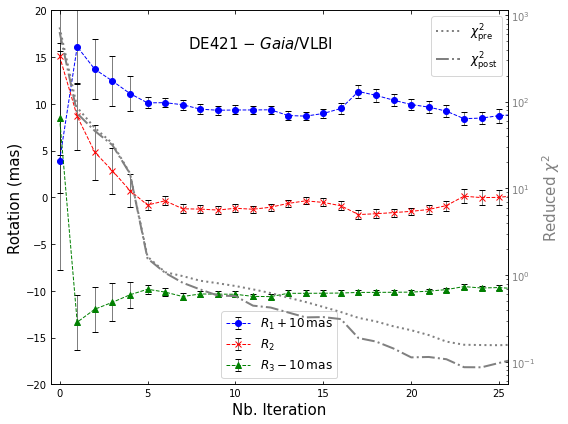

In [60]:
rot_vs_iter(
    pmt421,
    sig421,
    [-0.5, 25.5, -20, 20],
    xaxis_range=np.arange(0, 26, 5),
    add_text=[0.3, 0.9, "DE421 $-$ $Gaia$/VLBI"],
    apr_chi2=apr_chi2_421,
    pst_chi2=pst_chi2_421,
    ax_loc="lower center",
    ax1_loc="upper right",
    elw=0.5,
    y_shift=10
)

In [61]:
rot421, iqr421 = find_pmt_est(pmt421)

dra_421, ddec_421 = calc_dpos(gv_timing421, rot421)

a_chi2_421, p_chi2_421 = calc_chi2_4_fit(gv_timing421, dra_421, ddec_421)

## 3.5 DE430 vs Gaia

In [62]:
# pmt430, sig430, indx, apr_chi2_430, pst_chi2_430 = rot_fit_4_table(
#     gv_timing430)

# rot430, iqr430 = find_pmt_est(pmt430)

In [63]:
# rot_vs_iter(
#     pmt430,
#     sig430,
#     [-0.5, 32.5, -50, 50],
#     apr_chi2=apr_chi2_430,
#     pst_chi2=pst_chi2_430,
#     add_text=[0.2, 0.92, "DE430 $-$ $Gaia$/VLBI"],
#     xaxis_range=np.arange(0, 31, 5),
#     ax_loc="lower center",
#     ax1_loc="upper left",
#     elw=0.5,
#     y_shift=20,

# )

## 3.6 DE436 vs Gaia

In [64]:
pmt436, sig436, indx, apr_chi2_436, pst_chi2_436 = rot_fit_4_table(
    gv_timing436)

rot436, iqr436 = find_pmt_est(pmt436)

dra_436, ddec_436 = calc_dpos(gv_timing436, rot436)

a_chi2_436, p_chi2_436 = calc_chi2_4_fit(gv_timing436, dra_436, ddec_436)

Iter.  NO.PSR  Apr.Chi2  Pos.Chi2  R1  R2  R3  rmPSR  rmPSREpoch  rmPSRChi2
Unit: mas
 1  6    255.8    176.0      13.89      18.62      -5.77 J1024-0719    56239   1732.8
 2  6    117.3    100.5       6.45       9.39      -2.71 J1024-0719    55636   1321.5
 3  6     43.7     42.0       1.73       3.09      -0.97 J1024-0719    55000    850.2
 4  5      0.8      0.5      -1.54      -0.68       0.51 J1012+5307    55000      1.7
 5  5      0.7      0.5      -1.62      -0.34       0.52 J1012+5307    55291      1.8
 6  5      0.6      0.4      -1.78       0.13       0.54 J1012+5307    55291      0.4
 7  5      0.5      0.4      -1.26      -0.24       0.52 J1012+5307    55000      1.0
 8  4      0.4      0.2       1.90      -1.74       0.46 J2145-0750    55322      1.1
 9  4      0.3      0.1       1.50      -1.79       0.21 J0437-4715    55000      0.5
10  3      0.3      0.1       0.48      -1.51       0.25 J2145-0750    55657      0.2
11  3      0.2      0.1       0.19      -1.48       0.

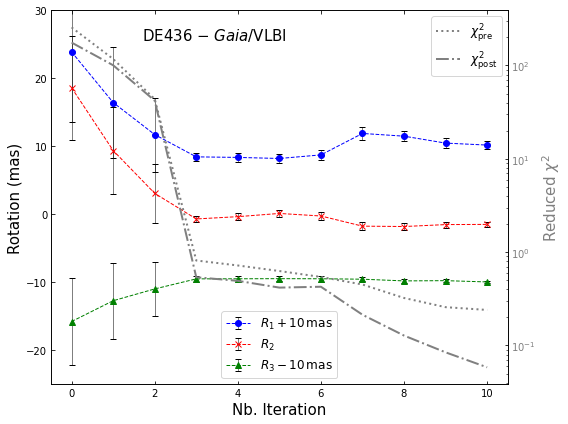

In [65]:
rot_vs_iter(
    pmt436,
    sig436,
    [-0.5, 10.5, -25, 30],
    apr_chi2=apr_chi2_436,
    pst_chi2=pst_chi2_436,
    #     xaxis_range=np.arange(0, 5, 31),
    add_text=[0.2, 0.92, "DE436 $-$ $Gaia$/VLBI"],
    ax_loc="lower center",
    ax1_loc="upper right",
    elw=0.5,
    y_shift=10
)

# 4 Summarize the results

The comparison of formal uncertainties of pulsar positions.

In [66]:
myheaders = ["RA_err_t", "dec_err_t", "pos_err_t",
             "RA_err_g", "dec_err_g", "pos_err_t"]
mystubs = ["DE200", "DE405", "DE421", "DE430", "DE436"]

tbl = SimpleTable(
    pos_err_tab,
    myheaders,
    mystubs,
    title="Positional formal uncertainty for timing and Gaia positions (mas)",
    data_fmts=["%6.2f", "%6.2f", "%6.2f", "%6.2f", "%6.2f", "%6.2f"],
)

print(tbl)

Positional formal uncertainty for timing and Gaia positions (mas)
      RA_err_t dec_err_t pos_err_t RA_err_g dec_err_g pos_err_t
---------------------------------------------------------------
DE200     1.08      2.00      2.27     0.80      0.82      1.15
DE405     2.04      3.00      4.49     0.70      0.63      0.95
DE421     0.14      0.45      0.47     0.75      0.74      1.05
DE430     7.38     20.32     21.62     1.48      3.00      3.38
DE436     0.08      0.19      0.21     1.18      1.00      1.55
---------------------------------------------------------------


A short table to summarize the orientation between DE frame and Gaia frame.

In [67]:
mydata = [
    [
        nb_psr_200,
        nb_obs_200,
        rot200[0],
        iqr200[0],
        rot200[1],
        iqr200[1],
        rot200[2],
        iqr200[2],
        a_chi2_200,
        p_chi2_200,
    ],
    [
        nb_psr_405,
        nb_obs_405,
        rot405[0],
        iqr405[0],
        rot405[1],
        iqr405[1],
        rot405[2],
        iqr405[2],
        a_chi2_405,
        p_chi2_405,
    ],
    [
        nb_psr_421,
        nb_obs_421,
        rot421[0],
        iqr421[0],
        rot421[1],
        iqr421[1],
        rot421[2],
        iqr421[2],
        a_chi2_421,
        p_chi2_421,
    ],
    # [
    #     nb_psr_430,
    #     nb_obs_430,
    #     rot430_a[0],
    #     iqr430_a[0],
    #     rot430_a[1],
    #     iqr430_a[1],
    #     rot430_a[2],
    #     iqr430_a[2],
    #     a_chi2_430,
    #     p_chi2_430,
    # ],
    [
        nb_psr_436,
        nb_obs_436,
        rot436[0],
        iqr436[0],
        rot436[1],
        iqr436[1],
        rot436[2],
        iqr436[2],
        a_chi2_436,
        p_chi2_436,
    ],
]

myheaders = [
    "Nb.PSR",
    "Nb.Obs",
    "R1",
    "R1_err",
    "R2",
    "R2_err",
    "R3",
    "R3_err",
    "ApreFitChi2",
    "PostFitChi2",
]
# mystubs = ["DE200", "DE405", "DE421", "DE430", "DE436"]
mystubs = ["DE200", "DE405", "DE421", "DE436"]

tbl = SimpleTable(
    mydata,
    myheaders,
    mystubs,
    title="Orientation of DE frame wrt. Gaia frame (mas)",
    data_fmts=[
        "%d",
        "%d",
        "%6.1f",
        "%6.1f",
        "%6.1f",
        "%6.1f",
        "%6.1f",
        "%6.1f",
        "%6.2f",
        "%6.2f",
    ],
)

print(tbl)

                    Orientation of DE frame wrt. Gaia frame (mas)                    
      Nb.PSR Nb.Obs   R1   R1_err   R2   R2_err   R3   R3_err ApreFitChi2 PostFitChi2
-------------------------------------------------------------------------------------
DE200      7     16    1.8    3.7  -16.1    7.7  -14.4    3.0       34.44        7.25
DE405      8     11   -0.6    1.8    0.1    1.1    0.2    1.4       29.45       29.59
DE421     13     30   -0.6    1.0   -0.8    1.0   -0.2    0.3      684.86      689.05
DE436      6     15    0.5    2.4   -0.3    2.3    0.2    0.7      229.37      230.46
-------------------------------------------------------------------------------------
